# Discrete grain size distribution
Outline:
1. Questions and assumptions
1. Idealized N ratio matrix
1. Distributed bins
1. Edge cases  

See slipbox journal entry 2024-08-12 for additional ideas 

## Questions and assumptions
1. For any fully-described grain size distribution (GSD), there exists a minimal packing set (MPS) of $n$ particles with various radii, $r$, needed to produce a discretized representation of the GDS.
2. Any GSD can be fully described as combinations of different special categories of GSD:
   1. Unique bins (perfect?): only one particle per bin
   2. Uniform bins: all particles in each bin have the same size
   3. Bounded bins: all particles in each bin are between two sizes.
3. GSDs from sieve analyses are "bounded bin" GSDs.
4. Within the bounds of a bin, a sub GSD exists.

For any target GSD, a set of tolerances can be provided to allow deviations between the target and the proposed GSD match.
Additionally, any other constraints (e.g., GSD category type) could be specified.

Within these constraints, what strategies are able to minimize the overall number of discrete particles needed to produce a tolerable match? This is the MPS.

The ability to find the MPS... is it significant? If it is very different than other packings that meet the criteria, then yes.
It's also significant if having a computationally feasible model that isn't a good match has significant mechanical differences from the system being modeled.
The MPS concept can be used to determine the goodness of fit between GSDs, the computational effort represented by these differences.

What is the relationship between MPS and the representative volume element (RVE)?

## Idealized N ratio matrix
Given a grain size distribution (GSD) of spherical particles, what is the minimum number of total particles, $N_{min,total}$, and the minimum number of particles of each size, $N_{min,i}$, to represent the GSD?
Let's say the GSD has $n$ bins.
Each bin contains a percentage, $\lambda$, of the total sample mass. 
Assuming the GSD consists of grains of the same density, $\lambda$ also represents the percentage by volume (of the grains in the sample, not the volume occupied by the sample).

For any two bins, $i$ and $j$, a ratio of the total volumes of the grains in the bins, $\phi_{i,j}$ can be described as the ratio of the volume percentages of the bins (i.e., $\phi_{i,j} = \lambda_i / \lambda_j$). 

Each bin has an associated size, which I'll use the grain radius, $r$, to describe. 
The ratio of the volumes of individual particles between the bins, $\xi_{i,j}$ can be described as the ratio of the cube of the bins' radii (i.e., $\xi_{i,j} = r_i^3 / r_j^3$). 

To achieve $\phi_{i,j}$, a ratio of the number of particles between the bins, $\nu_{i,j}$, can be found as $\phi_{i,j} / \xi_{i,j}$

It's fairly straightforward to represent any GSD with matricies for $\phi$, $\xi$, and $\nu$.
If the lower diagonal of $\nu$ are all integers, each row of the first column of $\nu$ will contain the number of particles in each bin for a representation of the GSD.
When the row of $\nu$ for the largest bin is the smallest possible integer to satisfy this condition, each entry in the first column of $\nu$ will be $N_{min,i}$ and the sum of these will be $N_{min,total}$. 

### Problems
This only works if the values in the lower left diagonal of $\nu$ can be represented with integers.
It's fine to do some rounding at some point, but I also want to have a way of calculating $N_{min,total}$ without adding error.
And when I do round, I want to be able to quantify the error and set a target.
Should the target be based on the overall sample and the percentage by volume? Or some other metric? 

#### Approaches
* Change the definition of $\lambda$ to be the bin *fraction* of the total volume of the sample.
* Set an allowable error and round numbers until a suitable GSD is achieved.
* Change the radius of the bin until it can match the required volume with an integer amount.
* Round the number of particles to the nearest integer from $\nu$. The thing I like about this approach is that it could be performed for several values of $N_{min,large}$ starting from 1 and increasing. Then all the possible conditions could be checked and their change could be observed with $N_{min,large}$. For each iteration, there would be multiple ways of rounding across the bins that could be used to minimize errors. This would be a top-down approach. 
* Bottom-up approach: find the numbers for the smallest and second-smallest bins and work up to the largest. I suspect this would find a large number for $N_{min,total}$.
* Accept that an infinite number of particles is needed and be satisfied with describing the distribution with the ratios in $\nu$.

#### Conditions
Some possible conditions that cound potentially be inforced:
* Total percentage adds up to 100.
* Each bin's volume is within some tolerance, $\epsilon$, as a percentage of the target volume for that bin.
* Each bin's volume is within some tolerance, $\epsilon$, as a percentage of the total sample volume, most likely informed by the volume of the smallest bin in the GSD.
* The particle size is within some tolerance, $\epsilon$, as a percentage of it's nominal size.
* The particle size is within the nominal bounds of adjacent bins.

Wait...

I'm not sure I need matricies at all. I could just use what I've been calling the first column of $\nu$, represent all entries as fractions, find the lowest common denominator, and multiply all entries by that number.

Let's give that a try:

OK, I think it worked, but I'm having fairly major issues with fractions blowing up. 

TODO: convert things to fractions earlier and see if that helps!

In [1]:
import gsd_lib as gl
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
p, r = gl.gsd_gen(4, size_ratio=10)

In [3]:
np.sum(p)

np.float64(1.0)

In [4]:
p = [.05, 0.5, 0.45]
new_r = [1.5, 2.5, 3.5]
# new_r = new_r[::-1]

In [6]:
d = gl.GSD(bins=new_r, contents=p, cont_type="weights")
print(p, new_r, d.min_particles, d.order, d.orders)

[0.05, 0.5, 0.45] [1.5, 2.5, 3.5] [ 8575 18522  6075] 4.0 [3. 4. 3.]


In [13]:
d.int_bins, d.bin_factor, d.int_weights, d.weight_factor

(array([ 3,  6,  9, 12]), 3, array([819, 420, 294, 567]), 294)

In [14]:
d.xi_n, d.phi_n, d.nu_n

(array([Fraction(64, 1), Fraction(8, 1), Fraction(64, 27), Fraction(1, 1)],
       dtype=object),
 array([Fraction(9, 13), Fraction(27, 20), Fraction(27, 14),
        Fraction(1, 1)], dtype=object),
 array([Fraction(832, 9), Fraction(160, 27), Fraction(896, 729),
        Fraction(1, 1)], dtype=object))

In [29]:
832/9

92.44444444444444

In [15]:
lcm = np.lcm.reduce([fr.denominator for fr in d.nu_n])
min_particles = np.asarray(
            [int(np.multiply(fr.numerator, lcm / fr.denominator, dtype=object)) for fr in d.nu_n])
print(lcm, min_particles)

729 [67392  4320   896   729]


By taking the floor division of $\nu$ from the distribution, $d$, we can get the closest distribution that has at least one bin with only one particle.

In [30]:
x = [nu.__floor__() for nu in d.nu_n]
d2 = gl.GSD(bins=new_r, contents=x, cont_type="particles")

Comparing the weights of $d$ and $d2$, we see a similar weight distribution. And we can calculate the error.
We can also calculate the difference in the number of particles by comparing the sum of x and the sum of `d.min_particles`

In [28]:
d2.weights, d.weights

(array([0.41255605, 0.1793722 , 0.12107623, 0.28699552]),
 array([0.39, 0.2 , 0.14, 0.27]))

In [35]:
e = abs(d2.weights - d.weights)/ d.weights
print(e)

[0.05783604 0.10313901 0.13516976 0.06294635]


In [38]:
np.sum(d.min_particles)
np.sum(x)

np.int64(99)

## Distributed bins

Imagine a bin with a lower limit of radius, $r_{low}$ and an upper limit of radius $r_{high}$. 
The distribution of the number of particle radii within the bin is given by a probability density function, $P(r)$.
Selecting a "representative" value for the bin, $r_{rep}$ would likely involve some measure of the average particle size, either by radius or volume. 
A representation based on volume is more appealing since the overall GSD is volume-weighted.

In absence of any other reason to suspect a specific distribution, a uniform distribution seems like a reasonable choice. 
Under a uniform distribution of radii, the mean radius would be the average of $r_{low}$ and $r_{high}$. 
The radius at the mean volume of this same distribution would given by:

$r_{rep} = r_{low} + \frac{r_{high}-r_{low}}{p}$

where $p$ is between $\sqrt[3]{4}$ and 2 and $\frac{r_{low}}{r_{high}}$ is between 0 and 1.

These come from the range of possible differences between the radius associated with the mean volume and the mean radius.
If $\frac{r_{low}}{r_{high}}$ is zero, there is no lower limit to the range (i.e., $r_{low}$ is infinitely small), $r_{mean} = r_{high}/2$, and the mean volume will be $\frac{\pi r_{high}^3}{3}$. The radius associated with the mean volume in this case is $\frac{r_{high}}{\sqrt[3]{4}}$. This corresponds to $p = \sqrt[3]{4}$.


As $\frac{r_{low}}{r_{high}}$ *approaches* one, the difference between $r_{low}$ and $r_{high}$ becomes very small and the radius associated with the mean volume approaches the mean radius. This corresponds to $p = 2$.
  
  
If $\frac{r_{low}}{r_{high}}$ is one, there is no difference between $r_{low}$ and $r_{high}$ (i.e., there is no variation in radii, making this a "perfect"(?) distribution), and the mean volume will be $\frac{4\pi r_{high}^3}{3}$. The radius associated with the mean volume in this case is simply $r_{high}$. This corresponds to an indeterminate condition for $p$.

Therefore, we can use the following equation to select an appropriate value of $p$ to describe a volume-based representative radius for a uniform distribution of particles between $r_{low}$ and $r_{high}$:

$p(\frac{r_{low}}{r_{high}}) = (2-\sqrt[3]{4})\frac{r_{low}}{r_{high}} + \sqrt[3]{4}$ with domain $D: [0,1]$ and range $R: [\sqrt[3]{4},2]$.

To confirm, create a plot of 1000 uniform distributions with $\frac{r_{low}}{r_{high}}$ between 0 and 1 with 1000 particles each and plot the resultant value of $p$ along with the analytical value.

*What about a normal distribution within the bounds? Perhaps normalish...*



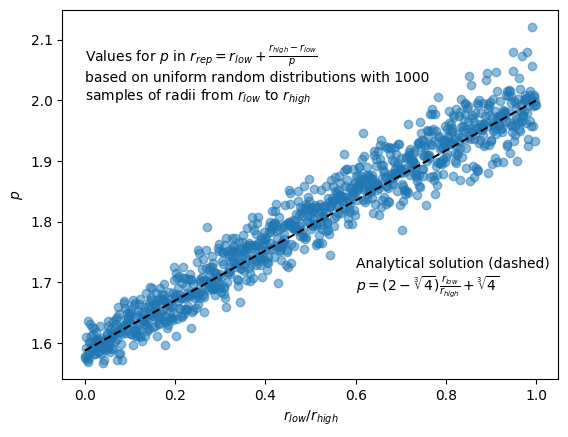

In [10]:
# Create a function that calculates p assuming that r_rep is the radius of a sphere with the same volume as the mean volume of the spheres in the distribution
def p_r_rep(r_low, r_high, size=1000, verbose=False):
    """
    Calculate the parameter 'p' from the radius of the mean volume of spheres with random uniformly distributed radii.
    """
    r = stats.uniform.rvs(loc=r_low, scale=r_high-r_low,size = size)
    v = 4/3*np.pi*r**3
    r_mean = np.mean(r)
    v_mean = np.mean(v)
    r_v_mean = (3*v_mean/(4*np.pi))**(1/3)
    if verbose:
        print(
        f"""For a uniform random distribution of radii from {r_low} to {r_high} with {size} samples, \nthe mean radius is {r_mean:.2f}, \nthe mean volume is {v_mean:.2f}, \nand the radius calculated from the mean volume is {r_v_mean:.2f}""")
    return (r_high-r_low)/(r_v_mean-r_low)

def p_analytical(r_low, r_high):
    return (2-4**(1/3))*(r_low/r_high) + 4**(1/3)

r_high = 10
size = 1000
r_ratio = np.linspace(0,0.999,size)
p = []
for r in r_ratio:
    p.append(p_r_rep(r_high*r, r_high))
plt.scatter(r_ratio, p, marker="o", alpha=0.5)
plt.plot([r_ratio[0],r_ratio[-1]], [p_analytical(r_high*r_ratio[0], r_high),p_analytical(r_high*r_ratio[-1], r_high)], linestyle="--", color="k")
plt.xlabel("$r_{low}/r_{high}$")
plt.ylabel("$p$")
text_plot = plt.text(0.0, 2.0, 
f"""Values for $p$ in $r_{{rep}} = r_{{low}} + \\frac{{r_{{high}}-r_{{low}}}}{{p}}$
based on uniform random distributions with {size} 
samples of radii from $r_{{low}}$ to $r_{{high}}$""")

text_plot = plt.text(0.6, 1.65, 
"""Analytical solution (dashed)
$p = (2-\\sqrt[3]{{4}}) \\frac{{r_{{low}}}}{{r_{{high}}}} + \\sqrt[3]{{4}}$
""")

## Edge cases
If bins have upper and lower bounds, the appropriate bounds for the first and last bins may not be available from experimental data.
*OK, now I'm getting away from mathematics and thinking too much about sieve analysis.*
I think it's safe to assume the largest bin would have an upper limit based on observation, if not an empty sieve.
The smallest size could have a lower bound approaching zero.
If that's assumed, the representative radius could be found using $p = \sqrt[3]{4}$.